# Install Library

[RDKit ](https://github.com/rdkit/rdkit)

[DGL](https://github.com/dmlc/dgl/)

[DGL-LifeSci](https://github.com/awslabs/dgl-lifesci)





In [ ]:
!pip install --pre dgl -f https://data.dgl.ai/wheels/cu113/repo.html
!pip install --pre dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [ ]:
%%capture
!pip install rdkit-pypi
!pip install dgllife

# Import Library

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'

import dgl 
import sys
import torch
import random
import statistics
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  History
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, AttentiveFPAtomFeaturizer
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split

from utils.general import DATASET, get_dataset, separate_active_and_inactive_data, get_embedding_vector_class, count_lablel,data_generator
from utils.gcn_pre_trained import get_tox21_model
from model.heterogeneous_siamese_tox21 import siamese_model_attentiveFp_tox21, siamese_model_Canonical_tox21


random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [2]:
cache_path='./tox21_dglgraph.bin'

df = get_dataset("tox21")
id = df['mol_id']
df = df.drop(columns=['mol_id'])

In [3]:
tox21_tasks = df.columns.values[:12].tolist()
tox21_tasks_test = tox21_tasks[9:12]
train_task, valid_task= train_test_split(tox21_tasks, test_size=0.2 , shuffle= False)

In [4]:
one = []
zero = []
nan = []
 
for task in tox21_tasks:
    a = list(df[task].value_counts(dropna=False).to_dict().values())
    zero.append(a[0])
    nan.append(a[1])
    one.append(a[2])
    print(task ,"one:" ,a[2] ," zero:", a[0], " NAN:",a[1])


NR-AR one: 309  zero: 6956  NAN: 566
NR-AR-LBD one: 237  zero: 6521  NAN: 1073
NR-AhR one: 768  zero: 5781  NAN: 1282
NR-Aromatase one: 300  zero: 5521  NAN: 2010
NR-ER one: 793  zero: 5400  NAN: 1638
NR-ER-LBD one: 350  zero: 6605  NAN: 876
NR-PPAR-gamma one: 186  zero: 6264  NAN: 1381
SR-ARE one: 942  zero: 4890  NAN: 1999
SR-ATAD5 one: 264  zero: 6808  NAN: 759
SR-HSE one: 372  zero: 6095  NAN: 1364
SR-MMP one: 918  zero: 4892  NAN: 2021
SR-p53 one: 423  zero: 6351  NAN: 1057


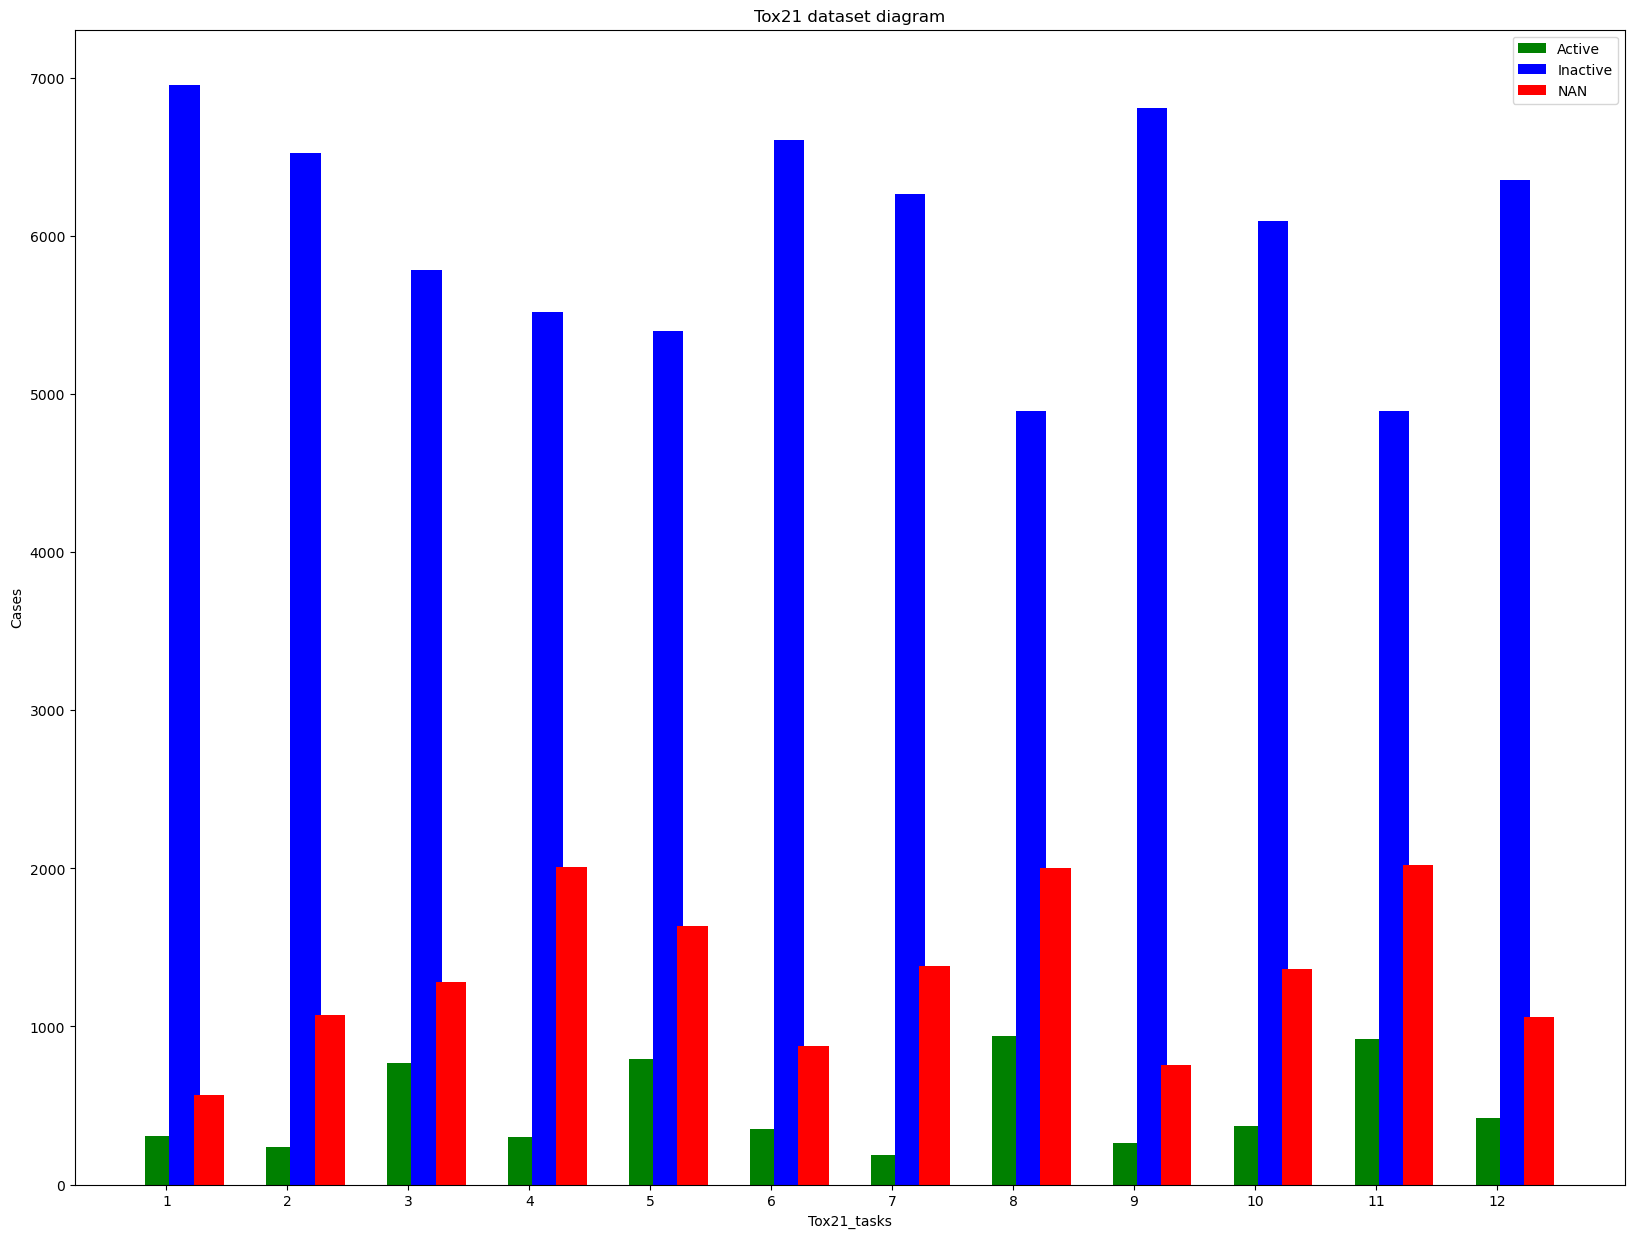

In [5]:
# Importing the matplotlib library
import numpy as np
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[20, 15])

X = np.arange(1,len(tox21_tasks)+1)
plt.bar(X + 0.2, one, color = 'g', width = 0.25)
plt.bar(X + 0.4, zero, color = 'b', width = 0.25)
plt.bar(X + 0.6, nan, color = 'r', width = 0.25)

# Creating the legend of the bars in the plot
plt.legend(['Active' , 'Inactive' ,'NAN'])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,13)], X)
# Giving the tilte for the plot
plt.title("Tox21 dataset diagram")
# Namimg the x and y axis
plt.xlabel('Tox21_tasks')
plt.ylabel('Cases')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()

# Required functions

In [37]:
def create_dataset_with_gcn(ds, class_embed_vector, GCN, tasks):

    created_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)
    for numberTask, dataset in enumerate(ds):
        for i, data in enumerate(dataset):
            smile, g, label, mask = data
            g = g.to(device)
            g = dgl.add_self_loop(g)
            graph_feats = g.ndata.pop('h')
            embbed = GCN(g, graph_feats)
            embbed = embbed.to('cpu')
            embbed = embbed.detach().numpy()
            a = (smiles, embbed, onehot_encoded[numberTask], class_embed_vector[numberTask], label, tasks[numberTask])
            created_data.append(a)
    print('Data created!!')
    return created_data 


def create_meta_data_gcn(GCN, dataset, class_embed_vector, train_task_size, tasks):
    
    train_data= []
    valid_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)
    
    for numberTask , datas in enumerate(dataset):
        
        for j, data in enumerate(datas):
            
            smiles, g, label, mask = data
            
            g = g.to(device)
            g = dgl.add_self_loop(g)
            graph_feats = g.ndata.pop('h')
            embbed = GCN(g, graph_feats)
            embbed = embbed.to('cpu')
            embbed = embbed.detach().numpy()
            a = (smiles, embbed, onehot_encoded[numberTask], class_embed_vector[numberTask], label[0], tasks[numberTask])

            
            if numberTask < train_task_size :
                train_data.append(a)
            else:
                valid_data.append(a)

    print('Data created!!')            
    return train_data, valid_data 

# Calculation of embedded vectors for each class 

In [8]:
df_positive, df_negative = separate_active_and_inactive_data (df, tox21_tasks)

for i,d in enumerate(zip(df_positive,df_negative)):
    print(f'{tox21_tasks[i]}=> positive: {len(d[0])} - negative: {len(d[1])}')

NR-AR=> positive: 309 - negative: 6956
NR-AR-LBD=> positive: 237 - negative: 6521
NR-AhR=> positive: 768 - negative: 5781
NR-Aromatase=> positive: 300 - negative: 5521
NR-ER=> positive: 793 - negative: 5400
NR-ER-LBD=> positive: 350 - negative: 6605
NR-PPAR-gamma=> positive: 186 - negative: 6264
SR-ARE=> positive: 942 - negative: 4890
SR-ATAD5=> positive: 264 - negative: 6808
SR-HSE=> positive: 372 - negative: 6095
SR-MMP=> positive: 918 - negative: 4892
SR-p53=> positive: 423 - negative: 6351


In [9]:
dataset_positive = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_positive]
dataset_negative = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_negative]

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/6956
Processing molecule 2000/6956
Processing molecule 3000/6956
Processing molecule 4000/6956
Processing molecule 5000/6956
Processing molecule 6000/6956
Processing dgl graphs from scratch...
Processing molecule 1000/6521
Processing molecule 2000/6521
Processing molecule 3000/6521
Processing molecule 4000/6521
Processing molecule 5000/6521
Processing molecule 6000/6521
Processing dgl graphs from scratch...
Processing molecule 1000/5781
Processing molecule 2000/5781
Processing

In [10]:
embed_class_tox21 = get_embedding_vector_class(dataset_positive, dataset_negative, radius=2, size = 512)

class vector created!!


# Meta-Learning with BioAct-Het and AttentiveFP GCN 

### Siamea model

In [11]:
#  Attentive FP GCN
model_name = 'GCN_attentivefp_Tox21'
gcn_model = get_tox21_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [12]:
data_ds = []
for i, task in  enumerate(tox21_tasks):
    a = df[['smiles' , task]]
    a = a.dropna()
    ds = DATASET(a, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path)
    data_ds.append(ds)

Processing dgl graphs from scratch...
Processing molecule 1000/7265
Processing molecule 2000/7265
Processing molecule 3000/7265
Processing molecule 4000/7265
Processing molecule 5000/7265
Processing molecule 6000/7265
Processing molecule 7000/7265
Processing dgl graphs from scratch...
Processing molecule 1000/6758
Processing molecule 2000/6758
Processing molecule 3000/6758
Processing molecule 4000/6758
Processing molecule 5000/6758
Processing molecule 6000/6758
Processing dgl graphs from scratch...
Processing molecule 1000/6549
Processing molecule 2000/6549
Processing molecule 3000/6549
Processing molecule 4000/6549
Processing molecule 5000/6549
Processing molecule 6000/6549
Processing dgl graphs from scratch...
Processing molecule 1000/5821
Processing molecule 2000/5821
Processing molecule 3000/5821
Processing molecule 4000/5821
Processing molecule 5000/5821
Processing dgl graphs from scratch...
Processing molecule 1000/6193
Processing molecule 2000/6193
Processing molecule 3000/6193


In [13]:
train_dataset, valid_dataset = create_meta_data_gcn (gcn_model, data_ds, embed_class_tox21, 9, tox21_tasks)

Data created!!


In [14]:
print(f'{len(train_dataset)}-{len(valid_dataset)}')

58895-19051


In [16]:
label_pos , label_neg, _ , _  = count_lablel(train_dataset)
print(f'train positive label: {label_pos} - train negative label: {label_neg}')

label_pos , label_neg, _ , _ = count_lablel(valid_dataset)
print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

train positive label: 4149 - train negative label: 54746
Test positive label: 1713 - Test negative label: 17338


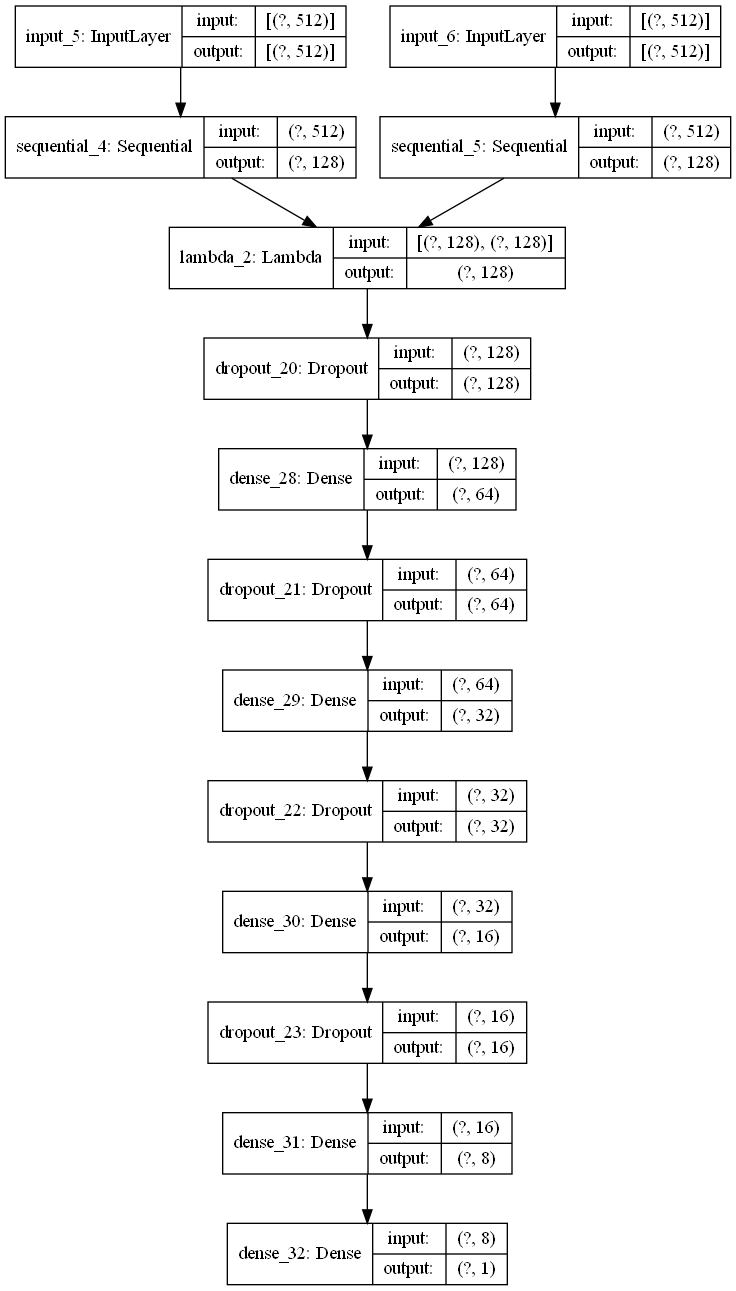

In [26]:
siamese_net = siamese_model_attentiveFp_tox21()

plot_model(siamese_net, show_shapes=True, show_layer_names=True)

### Training algorithm

In [27]:
# models = [siamese_net for task in sider_tasks_final]
Epoch_S = 15
l = []
r = []
lbls = []
for i , data in enumerate(train_dataset):
    smile, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
    l.append(embbed_drug[0])
    r.append(embbed_task)
    lbls.append(lbl.tolist())

l = np.array(l).reshape(-1,512,1)
r = np.array(r).reshape(-1,512,1)
lbls=np.array(lbls)

history = History()

P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=[history])

for j in range(1000):
    C=1
    Before = int(P.history['accuracy'][-1]*100)
    for i in range(2,Epoch_S+1):
        if  int(P.history['accuracy'][-i]*100)== Before:
            C=C+1
        else:
            C=1
        Before=int(P.history['accuracy'][-i]*100)
        print(Before)
    if C==Epoch_S:
        break
    P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=history)
print(j+1)


Epoch 1/15
461/461 [==============================] - 2s 5ms/step - loss: 0.2381 - accuracy: 0.9274 - mae: 0.1303 - mse: 0.0626 - auc_2: 0.7583
Epoch 2/15
461/461 [==============================] - 2s 5ms/step - loss: 0.2111 - accuracy: 0.9295 - mae: 0.1163 - mse: 0.0564 - auc_2: 0.8096
Epoch 3/15
461/461 [==============================] - 2s 5ms/step - loss: 0.2033 - accuracy: 0.9297 - mae: 0.1128 - mse: 0.0549 - auc_2: 0.8254
Epoch 4/15
461/461 [==============================] - 2s 5ms/step - loss: 0.2002 - accuracy: 0.9302 - mae: 0.1107 - mse: 0.0542 - auc_2: 0.8302
Epoch 5/15
461/461 [==============================] - 2s 5ms/step - loss: 0.1960 - accuracy: 0.9326 - mae: 0.1078 - mse: 0.0530 - auc_2: 0.8366
Epoch 6/15
461/461 [==============================] - 2s 5ms/step - loss: 0.1937 - accuracy: 0.9335 - mae: 0.1066 - mse: 0.0526 - auc_2: 0.8413
Epoch 7/15
461/461 [==============================] - 2s 5ms/step - loss: 0.1907 - accuracy: 0.9342 - mae: 0.1049 - mse: 0.0518 - auc_2:

### Model evaluation

In [28]:
valid_ds = {}

for i, task in enumerate(tox21_tasks_test):
    temp = []
    for j , data in enumerate(valid_dataset):
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        if task ==  task_name:
            temp.append(data)
    
    valid_ds[task] = temp


In [30]:
task_scores = [tox21_tasks_test for tox21_tasks_test in range(len(tox21_tasks_test))]

for i, task in enumerate(tox21_tasks_test):
    print(task,": ")

    y_test = []
    l_val = []
    r_val = []
    lbls_valid = []
    for data in valid_ds[task]:
       
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        l_val.append(embbed_drug[0])
        r_val.append(embbed_task)
        lbls_valid.append(lbl)
            
    l1 = np.asarray(l_val)
    r1 = np.asarray(r_val)
    lbls_valid = np.asarray(lbls_valid)

    score = siamese_net.evaluate([l1,r1],lbls_valid)
 
    result =(score[1], score[4])
    task_scores[i] = task,result

SR-HSE : 
203/203 [==============================] - 0s 680us/step - loss: 0.1902 - accuracy: 0.9436 - mae: 0.1187 - mse: 0.0497 - auc_2: 0.8065
SR-MMP : 
182/182 [==============================] - 0s 638us/step - loss: 0.3174 - accuracy: 0.8551 - mae: 0.1819 - mse: 0.0990 - auc_2: 0.8642
SR-p53 : 
212/212 [==============================] - 0s 637us/step - loss: 0.1848 - accuracy: 0.9401 - mae: 0.1171 - mse: 0.0503 - auc_2: 0.8498


# Meta-Learning with BioAct-Het and Canonical GCN

### Siamea model

In [36]:
model_GCN = 'GCN_canonical_Tox21'
gcn_model = get_tox21_model(model_GCN)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [37]:
data_ds = []
for i, task in  enumerate(tox21_tasks):
    a = df[['smiles' , task]]
    a = a.dropna()
    ds = DATASET(a, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path)
    data_ds.append(ds)

Processing dgl graphs from scratch...
Processing molecule 1000/7265
Processing molecule 2000/7265
Processing molecule 3000/7265
Processing molecule 4000/7265
Processing molecule 5000/7265
Processing molecule 6000/7265
Processing molecule 7000/7265
Processing dgl graphs from scratch...
Processing molecule 1000/6758
Processing molecule 2000/6758
Processing molecule 3000/6758
Processing molecule 4000/6758
Processing molecule 5000/6758
Processing molecule 6000/6758
Processing dgl graphs from scratch...
Processing molecule 1000/6549
Processing molecule 2000/6549
Processing molecule 3000/6549
Processing molecule 4000/6549
Processing molecule 5000/6549
Processing molecule 6000/6549
Processing dgl graphs from scratch...
Processing molecule 1000/5821
Processing molecule 2000/5821
Processing molecule 3000/5821
Processing molecule 4000/5821
Processing molecule 5000/5821
Processing dgl graphs from scratch...
Processing molecule 1000/6193
Processing molecule 2000/6193
Processing molecule 3000/6193


In [38]:
train_dataset, valid_dataset = create_meta_data_gcn (gcn_model, data_ds, embed_class_tox21, 9, tox21_tasks)

Data created!!


In [42]:
label_pos , label_neg, _ , _ = count_lablel(train_dataset)
print(f'train positive label: {label_pos} - train negative label: {label_neg}')

label_pos , label_neg, _ , _ = count_lablel(train_dataset)
print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

train positive label: 4149 - train negative label: 54746
Test positive label: 4149 - Test negative label: 54746


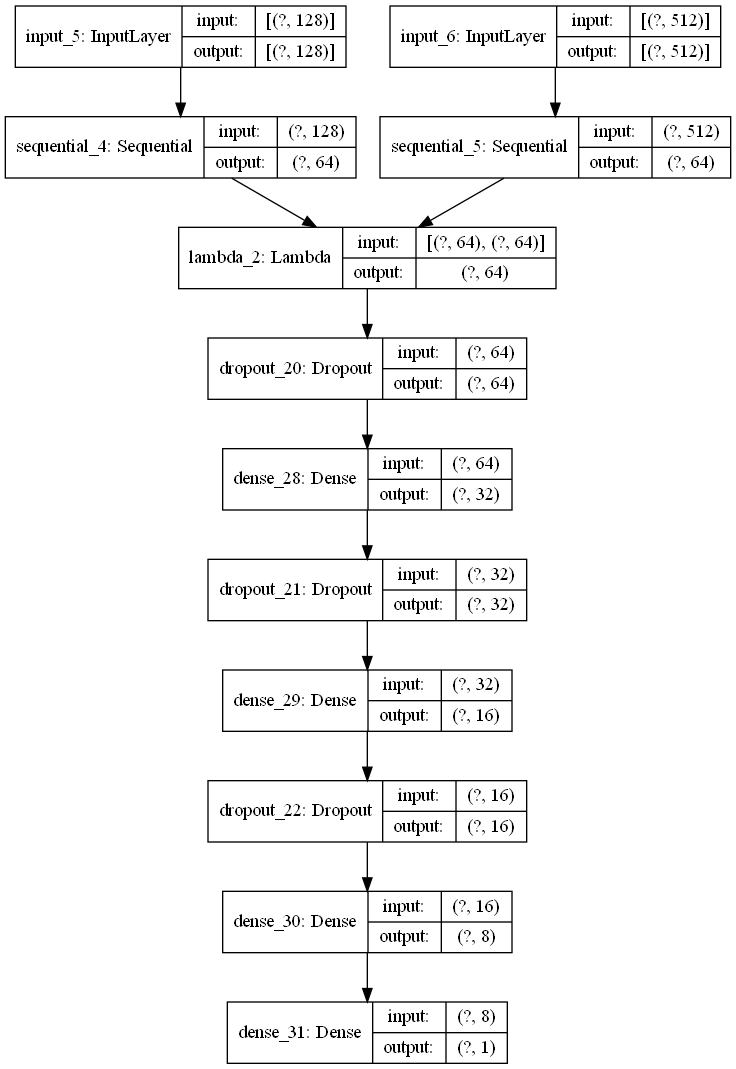

In [43]:
siamese_net = siamese_model_Canonical_tox21()

plot_model(siamese_net, show_shapes=True, show_layer_names=True)

### Training algorithm

In [44]:
# models = [siamese_net for task in sider_tasks_final]
Epoch_S = 15
l = []
r = []
lbls = []
for i , data in enumerate(train_dataset):
    smile, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
    l.append(embbed_drug[0])
    r.append(embbed_task)
    lbls.append(lbl.tolist())

l = np.array(l).reshape(-1,128,1)
r = np.array(r).reshape(-1,512,1)
lbls=np.array(lbls)

history = History()

P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=[history])

for j in range(1000):
    C=1
    Before = int(P.history['accuracy'][-1]*100)
    for i in range(2,Epoch_S+1):
        if  int(P.history['accuracy'][-i]*100)== Before:
            C=C+1
        else:
            C=1
        Before=int(P.history['accuracy'][-i]*100)
        print(Before)
    if C==Epoch_S:
        break
    P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=history)
print(j+1)


Epoch 1/15
461/461 [==============================] - 2s 4ms/step - loss: 0.2525 - accuracy: 0.9287 - mae: 0.1362 - mse: 0.0656 - auc_2: 0.7061
Epoch 2/15
461/461 [==============================] - 2s 4ms/step - loss: 0.2199 - accuracy: 0.9296 - mae: 0.1218 - mse: 0.0590 - auc_2: 0.7873
Epoch 3/15
461/461 [==============================] - 2s 4ms/step - loss: 0.2125 - accuracy: 0.9297 - mae: 0.1179 - mse: 0.0576 - auc_2: 0.8058
Epoch 4/15
461/461 [==============================] - 2s 4ms/step - loss: 0.2103 - accuracy: 0.9296 - mae: 0.1158 - mse: 0.0569 - auc_2: 0.8094
Epoch 5/15
461/461 [==============================] - 2s 4ms/step - loss: 0.2069 - accuracy: 0.9304 - mae: 0.1140 - mse: 0.0561 - auc_2: 0.8160
Epoch 6/15
461/461 [==============================] - 2s 4ms/step - loss: 0.2049 - accuracy: 0.9310 - mae: 0.1117 - mse: 0.0554 - auc_2: 0.8181
Epoch 7/15
461/461 [==============================] - 2s 4ms/step - loss: 0.2033 - accuracy: 0.9309 - mae: 0.1110 - mse: 0.0552 - auc_2:

### Model evaluation

In [45]:
valid_ds = {}

for i, task in enumerate(tox21_tasks_test):
    temp = []
    for j , data in enumerate(valid_dataset):
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        if task ==  task_name:
            temp.append(data)
    
    valid_ds[task] = temp

In [46]:
task_scores = [tox21_tasks_test for tox21_tasks_test in range(len(tox21_tasks_test))]

for i, task in enumerate(tox21_tasks_test):
    print(task,": ")

    y_test = []
    l_val = []
    r_val = []
    lbls_valid = []
    for data in valid_ds[task]:
       
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        l_val.append(embbed_drug[0])
        r_val.append(embbed_task)
        lbls_valid.append(lbl)
            
    l1 = np.asarray(l_val)
    r1 = np.asarray(r_val)
    lbls_valid = np.asarray(lbls_valid)

    score = siamese_net.evaluate([l1,r1],lbls_valid)
 
    result =(score[1], score[4])
    task_scores[i] = task,result


SR-HSE : 
203/203 [==============================] - 0s 784us/step - loss: 0.1890 - accuracy: 0.9394 - mae: 0.1164 - mse: 0.0499 - auc_2: 0.8020
SR-MMP : 
182/182 [==============================] - 0s 753us/step - loss: 0.3250 - accuracy: 0.8642 - mae: 0.1974 - mse: 0.0994 - auc_2: 0.8466
SR-p53 : 
212/212 [==============================] - 0s 732us/step - loss: 0.1863 - accuracy: 0.9377 - mae: 0.1156 - mse: 0.0504 - auc_2: 0.8412
